# Loading libraries

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from matplotlib.offsetbox import AnchoredText
import mpl_toolkits.mplot3d.axes3d as axes3d

# Define functions

In [2]:
def createNDimensionBall(ndim=2, nsamples=2000):
    norm = np.random.normal
    normal_deviates = norm(size=(ndim, nsamples))

    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius
    return points.T

In [3]:
def reassignLabels(labels):
    ncols = labels.shape[1]
    labelDict = {}
    newLabels = np.zeros(ncols)
    newLabel = 1
    index = -1
    for j in range(ncols):
        key = tuple(labels[:,j])
        if key not in labelDict:
            labelDict[key] = newLabel
            newLabel += 1
        newLabels[index] = labelDict[key]
        index += 1
    return newLabels

In [4]:
def calEntropy(labels):
    unique, counts = np.unique(labels, return_counts=True)
#     prob = counts / counts.sum()
#     return -np.sum(prob * np.log10(prob))
    return np.max(unique)

In [5]:
def expand2DimensionalSamples(data, d, mu=0, sigma=0.01):
    newdata = np.random.normal(mu, sigma, size=(data.shape[0], data.shape[1]+d))
    newdata[:, :data.shape[1]] = data
    return newdata

In [6]:
def getEntropy(data, x, nIters, kClusters, reorder=10):
    labels = getClusteringLabels(data, n=nIters, k=kClusters)
    entropies = []
    for re in range(reorder):
        np.random.shuffle(labels)
        entropies.append([calEntropy(reassignLabels(labels[:i,:])) for i in x])
    entropies = np.array(entropies)
    return np.mean(entropies, axis=0), np.std(entropies, axis=0)

In [7]:
def plotClusters(data, labels, kClusters, ax=None):
    ax = ax or getDefaultAxis()
    for k in range(kClusters):
        ck = data[labels == k]
        ax.scatter(*ck.T)
    return ax

In [8]:
def getClusteringLabels(data, n, k):
    labels = []
    for i in range(n):
        clusterings = MiniBatchKMeans(n_clusters=k, random_state=np.random.randint(2**32)).fit(data)
        labels.append(clusterings.labels_)
    return np.array(labels)

In [20]:
def gridplot(x, y, label, ax=None):
    ax.set_xlabel('logm ~ (number of runs)')
    ax.set_ylabel('logn ~ (entropy)')
    ax = ax or plt.gca()
    ax.plot(x, y, label=label)
    maxNum = math.ceil(max(np.max(y), np.max(x)))
    tickets = np.arange(maxNum+1)
    ax.set_xlim([0, maxNum])
    ax.set_ylim([0, maxNum])
    ax.set_xticks(tickets)
    ax.set_yticks(tickets)
    ax.grid(True)
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    return ax

In [10]:
def addKPoints(x, y, ax, k=4):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    step = len(x)//50
    pointtext = '({:.2f}, {:.2f})'
    slope = 0
    xp = None
    yp = None
    for i, k in enumerate([0,2,8,32]):
        xn = x[step*k]
        yn = y[step*k]
        if xp:
            slope = max((yn-yp)/(xn-xp), slope)
        ax.scatter(x[step*k], y[step*k], color='black')
        ax.annotate(pointtext.format(x[step*k], y[step*k]), (x[step*k], y[step*k]))
        xp = x[step*k]
        yp = y[step*k]
    ax.text(x[-1]+0.1, y[-1], 'slope ~ {:.2f}'.format(slope))
    return ax

In [11]:
plt.rcParams["figure.figsize"] = (8,8)

nsamples = 2000
nIters = 100
x = np.arange(2, nIters)

# 2-dimension ball (intrinsic=1)

Here we create a 2d ball using joint normal probability distribution. The intrinsic dimension of the 2d ball is 1. We would like to determine the intrinsic dimension using Entropy-analysis method. We run a non-determinisitic clustering algorithm on the data samples multiple times, and caculate the joint entropy after many runs, then draw the log-log plot.

Say
+ `m` is the number of runs
+ `k` is the number of clusters
+ `d` is the intrinsic dimensions
+ `n` is the number of parts after  `m` runs

Then there should be an relationship about:

\begin{equation*}
 n = m^d * k
\end{equation*}

taking the log from each side, we have

\begin{equation*}
 log(entropy) \approx log(n) = log(k) + d*log(m)
\end{equation*}

If we draw the log-log plot of `n` and `m`, the slope of the plot is the intrinsic dimension of the data. 

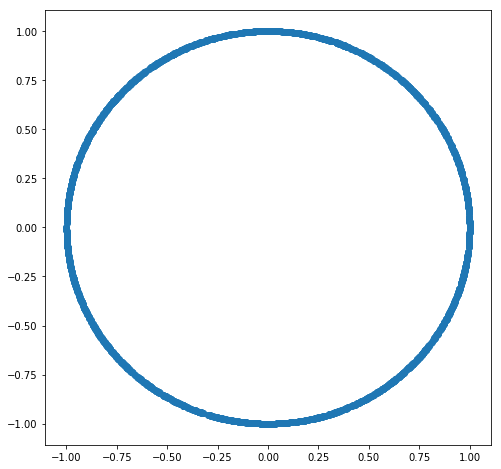

In [12]:
data = createNDimensionBall(ndim=2, nsamples=nsamples)
plt.scatter(*data.T)
plt.show()

Using non-deterministic clustering algorithm (Kmeans++), we are able to partition the data into two differently each run

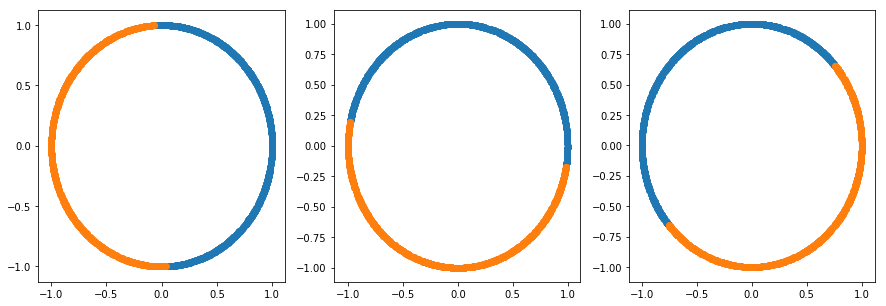

In [14]:
kClusters = 2
fig, ((ax4,ax5,ax6)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
data = createNDimensionBall(ndim=2)
labels = getClusteringLabels(data, n=3, k=kClusters)
ax4 = plotClusters(data, labels[0], kClusters, ax=ax4)
ax5 = plotClusters(data, labels[1], kClusters, ax=ax5)
ax6 = plotClusters(data, labels[2], kClusters, ax=ax6)
plt.show()

If we keep running the clustering algorithm for `m` times, we draw the `log(n)` vs. `log(m)` plot. Here we can see the slope of the plot is `1`, which corresponds to the intrinsic dimension of the 2d ball we just created.

In [15]:
kClusters = 2
means, std = getEntropy(data, x, nIters, kClusters)

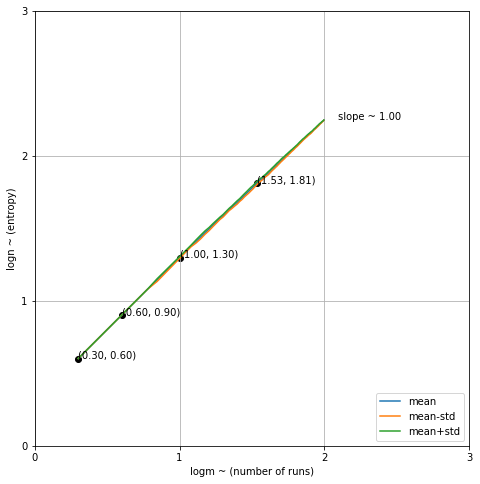

In [21]:
ax = plt.gca()
ax = gridplot(np.log10(x), np.log10(means), 'mean', ax=ax)
ax = gridplot(np.log10(x), np.log10(means-std), 'mean-std', ax=ax)
ax = gridplot(np.log10(x), np.log10(means+std), 'mean+std', ax=ax)
ax = addKPoints(np.log10(x), np.log10(means), ax)

### add extra 50 dimension noise

In order to embed the 2d ball into higher dimension space, here we add extra 50 dimension noise (normal distribution noise). As can see below, with small noise`(std=0.1)` added, the slope doesn't change much. With larger noise`(std=0.5)` added, the slope has increased a lot. Meaning that the data isn't perfectly `1` intrinsic dimension.

In [22]:
kClusters = 2
entropies = []
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.1), x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.2), x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.3), x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.5), x, nIters, kClusters)[0])

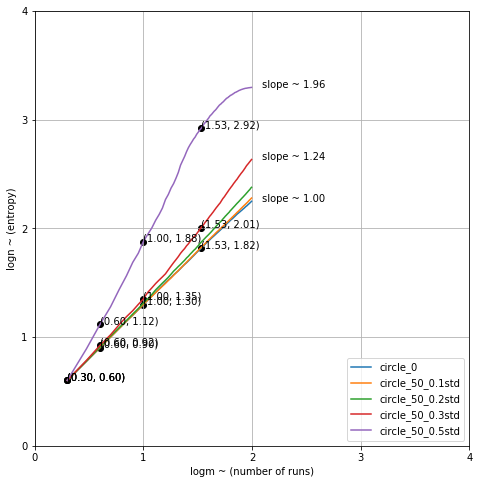

In [25]:
ax = plt.gca()
labels = ['circle_0', 'circle_50_0.1std', 'circle_50_0.2std', 'circle_50_0.3std', 'circle_50_0.5std']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
ax = addKPoints(np.log10(x), np.log10(entropies[0]), ax)
ax = addKPoints(np.log10(x), np.log10(entropies[-2]), ax)
ax = addKPoints(np.log10(x), np.log10(entropies[-1]), ax)

### experiment with different clusters

Here we take experiment using different number of clusters. As we can see below, increasing the number of clusters does not change the slope (intrinsic dimension) but shift the line higher, which means we increase the entropy X-intercept by increase `log(k)` (with more clusters).

\begin{equation*}
 log(entropy) \approx log(n) = log(k) + d*log(m)
\end{equation*}


In [26]:
entropies = []
entropies.append(getEntropy(data, x, nIters, kClusters=2)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=5)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=10)[0])

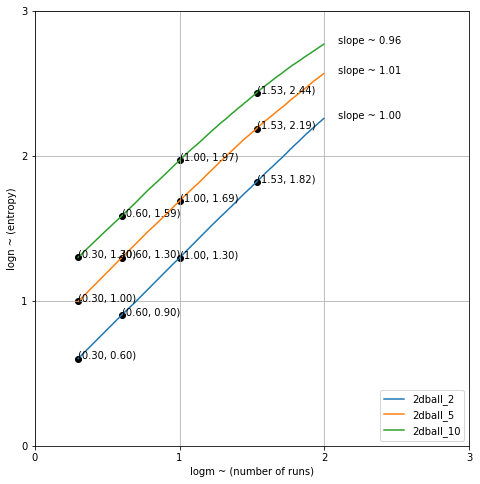

In [27]:
ax = plt.gca()
labels = ['2dball_2', '2dball_5', '2dball_10']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
    ax = addKPoints(np.log10(x), np.log10(entropies[i]), ax)

# 3-dimension ball (intrinsic=2)

Now lets look at another example, a 3-d ball, which is generated using joint normal distribution. It is clear that the 3-d ball has intrinsic dimension 2 (by looking at any particular point, surrouding it is a 2-d surface).

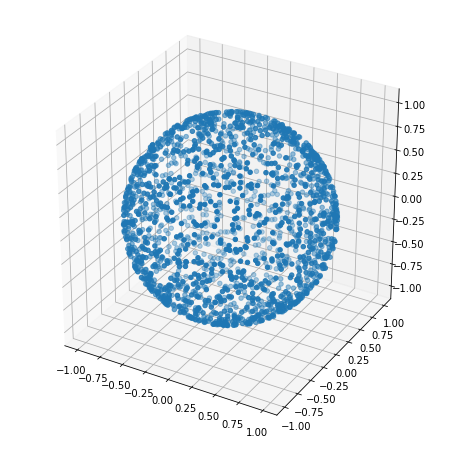

In [28]:
data = createNDimensionBall(ndim=3,  nsamples=nsamples)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(*data.T)
ax.set_aspect('equal')
plt.show()

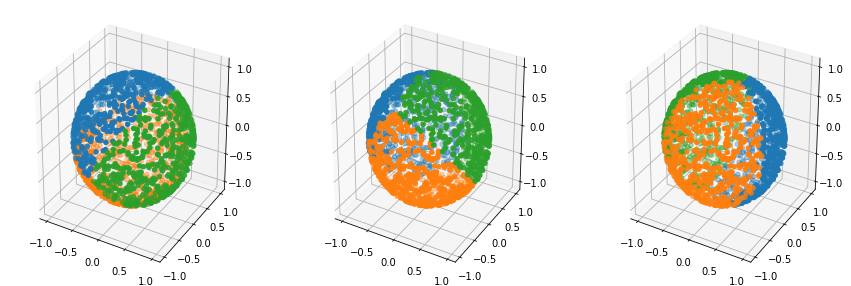

In [29]:
kClusters = 3
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131,projection='3d')
ax2 = fig.add_subplot(132,projection='3d')
ax3 = fig.add_subplot(133,projection='3d')

labels = getClusteringLabels(data, n=3, k=kClusters)
ax1 = plotClusters(data, labels[0], kClusters, ax=ax1)
ax2 = plotClusters(data, labels[1], kClusters, ax=ax2)
ax3 = plotClusters(data, labels[2], kClusters, ax=ax3)
plt.show()

## kClusters = 2

In [30]:
kClusters = 2
data = createNDimensionBall(ndim=3, nsamples=nsamples)
means, std = getEntropy(data, x, nIters, kClusters)

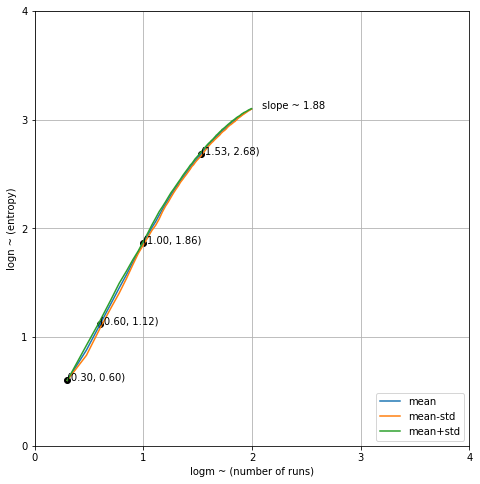

In [31]:
ax = plt.gca()
ax = gridplot(np.log10(x), np.log10(means), 'mean', ax=ax)
ax = gridplot(np.log10(x), np.log10(means-std), 'mean-std', ax=ax)
ax = gridplot(np.log10(x), np.log10(means+std), 'mean+std', ax=ax)
ax = addKPoints(np.log10(x), np.log10(means), ax)

### add extra 50 dimension noise

In [32]:
kClusters = 2
entropies = []
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.1), x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.2), x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.3), x, nIters, kClusters)[0])
entropies.append(getEntropy(expand2DimensionalSamples(data, d=50, sigma=0.5), x, nIters, kClusters)[0])

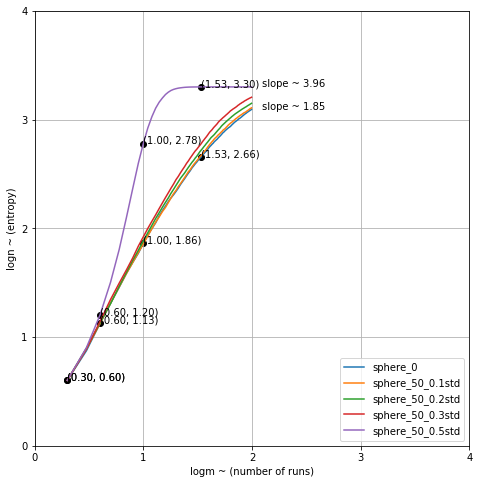

In [35]:
ax = plt.gca()
labels = ['sphere_0', 'sphere_50_0.1std', 'sphere_50_0.2std', 'sphere_50_0.3std', 'sphere_50_0.5std']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
ax = addKPoints(np.log10(x), np.log10(entropies[0]), ax)
ax = addKPoints(np.log10(x), np.log10(entropies[-1]), ax)

### extra clusters

It turns out with adding more clusters, the intrinsic dimension recovery does not improve.

In [36]:
data = createNDimensionBall(ndim=3, nsamples=nsamples)

entropies = []
entropies.append(getEntropy(data, x, nIters, kClusters=2)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=5)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=10)[0])

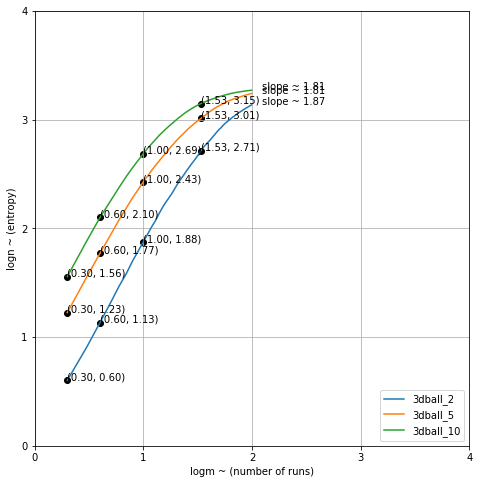

In [37]:
ax = plt.gca()
labels = ['3dball_2', '3dball_5', '3dball_10']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
    ax = addKPoints(np.log10(x), np.log10(entropies[i]), ax)

## extra samples

It turns out with adding more samples, the intrinsic dimension recovery improves from `1.88` to `1.95` (closer to the ground truth).

In [38]:
kClusters = 2
entropies = []
data = createNDimensionBall(ndim=3, nsamples=2000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = createNDimensionBall(ndim=3, nsamples=3000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = createNDimensionBall(ndim=3, nsamples=5000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = createNDimensionBall(ndim=3, nsamples=10000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])

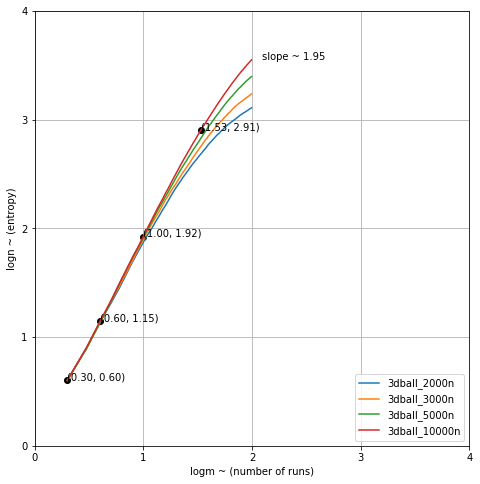

In [39]:
ax = plt.gca()
labels = ['3dball_2000n', '3dball_3000n', '3dball_5000n', '3dball_10000n']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
ax = addKPoints(np.log10(x), np.log10(entropies[-1]), ax)

## 4-dimension ball (ID=3)

In [40]:
nsamples = 10000
data = createNDimensionBall(ndim=4, nsamples=nsamples)
data.shape

(10000, 4)

In [41]:
kClusters = 3
means, std = getEntropy(data, x, nIters, kClusters)

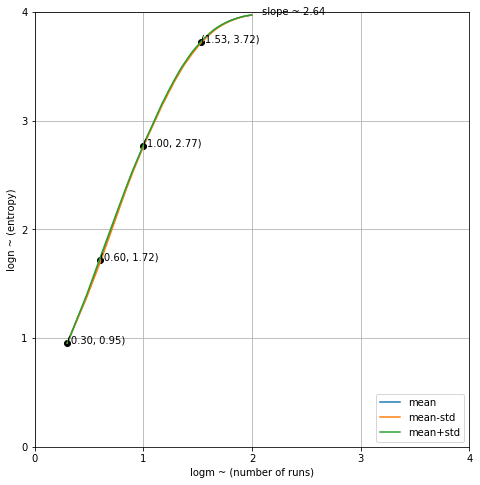

In [42]:
ax = plt.gca()
ax = gridplot(np.log10(x), np.log10(means), 'mean', ax=ax)
ax = gridplot(np.log10(x), np.log10(means-std), 'mean-std', ax=ax)
ax = gridplot(np.log10(x), np.log10(means+std), 'mean+std', ax=ax)
ax = addKPoints(np.log10(x), np.log10(means), ax)

##  extra samples

With the help of more samples, we approximate the ID = 3 ball as slope `~2.87` (improved from `~2.64`).

In [43]:
entropies = []
data = createNDimensionBall(ndim=4, nsamples=10000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = createNDimensionBall(ndim=4, nsamples=20000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = createNDimensionBall(ndim=4, nsamples=50000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])

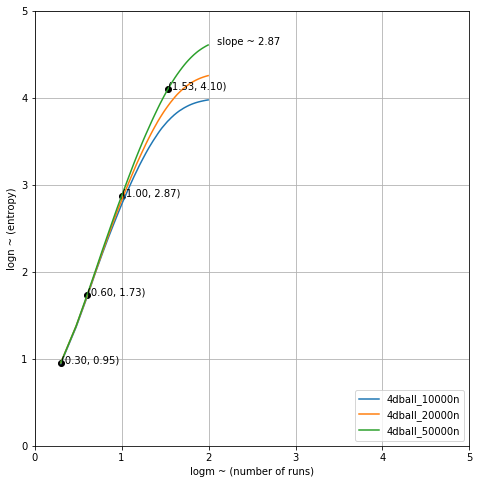

In [44]:
ax = plt.gca()
labels = ['4dball_10000n', '4dball_20000n', '4dball_50000n']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
ax = addKPoints(np.log10(x), np.log10(entropies[-1]), ax)

# swiss_roll (ID=2)

In [45]:
from sklearn.datasets import make_swiss_roll
import mpl_toolkits.mplot3d.axes3d as p3

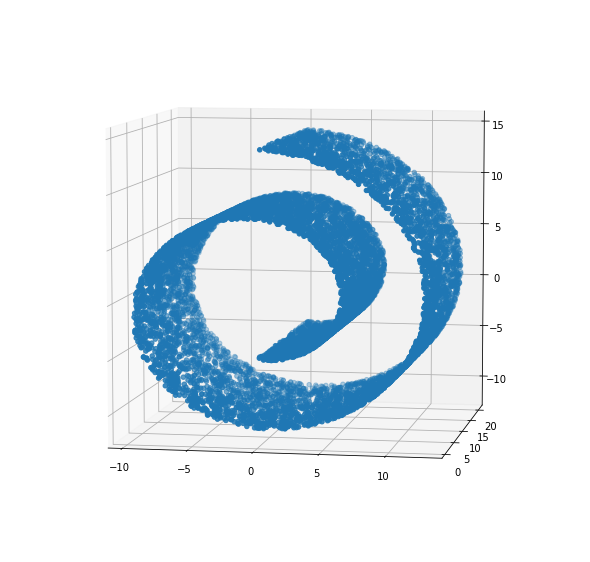

In [46]:
noise = 0.0
sr_data, _ = make_swiss_roll(n_samples=nsamples, noise=noise, random_state=None)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)

ax.scatter(*sr_data.T)
ax.set_aspect('equal')
plt.show()

Adding sample size does not improve the ID recovery accuracy for swiss roll problem.

In [47]:
entropies = []
kClusters = 2
data, _ = make_swiss_roll(n_samples=10000, noise=noise, random_state=None)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data, _ = make_swiss_roll(n_samples=20000, noise=noise, random_state=None)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data, _ = make_swiss_roll(n_samples=30000, noise=noise, random_state=None)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])

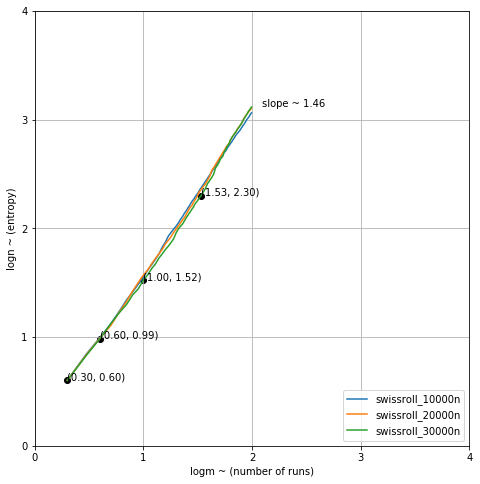

In [48]:
ax = plt.gca()
labels = ['swissroll_10000n', 'swissroll_20000n', 'swissroll_30000n']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
ax = addKPoints(np.log10(x), np.log10(entropies[-1]), ax)

### more clusters

Given `nsamples = 10000`, When kClusters increases (`k=12`), the ID recovery is more accurate. The slope we found `~1.92` which approximate the ID=2.

In [49]:
entropies = []
data, _ = make_swiss_roll(n_samples=10000, noise=noise, random_state=None)
entropies.append(getEntropy(data, x, nIters, kClusters=2)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=8)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=10)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=12)[0])

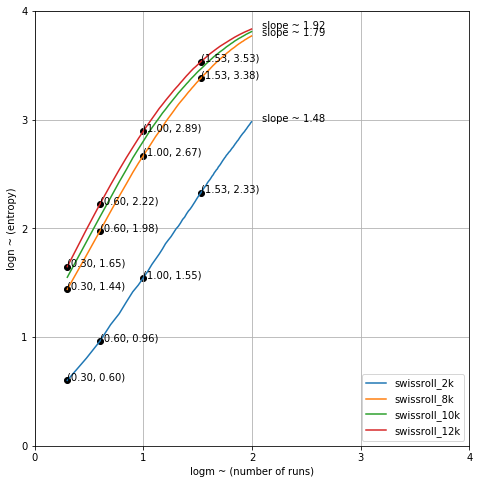

In [50]:
ax = plt.gca()
labels = ['swissroll_2k', 'swissroll_8k', 'swissroll_10k', 'swissroll_12k']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
    if i == 2: continue
    ax = addKPoints(np.log10(x), np.log10(entropies[i]), ax)

# rectangle (ID=2)

In [51]:
def rectangle(nsamples=5000):
    x = np.random.uniform(0,1,nsamples)
    y = np.random.uniform(0,1,nsamples)
    return np.stack([x,y]).T

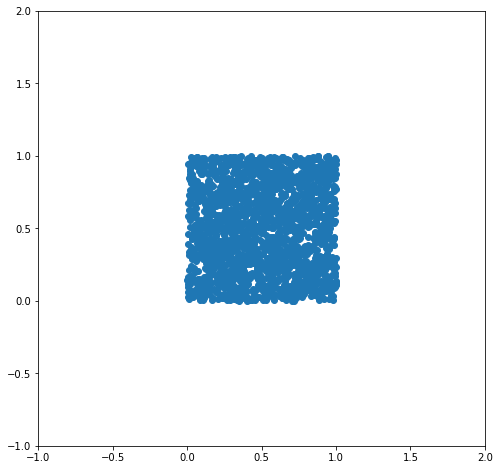

In [53]:
data = rectangle(nsamples=2000)
plt.scatter(data[:,0],data[:,1])
plt.xlim(-1,2)
plt.ylim(-1,2)
means, std = getEntropy(data, x, nIters, kClusters)

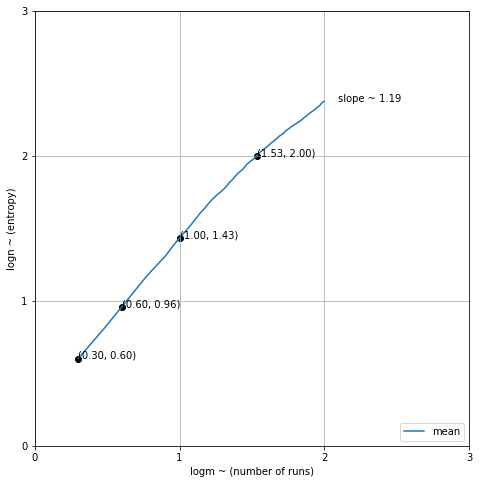

In [54]:
ax = plt.gca()
ax = gridplot(np.log10(x), np.log10(means), 'mean', ax=ax)
ax = addKPoints(np.log10(x), np.log10(means), ax)

### more samples

Adding sample size does help improve ID recovery accuracy, from `~1.22` to `~1.58`, but not that substantial comparing to adding cluster size as shown next.

In [55]:
entropies = []
kClusters = 2
data = rectangle(nsamples=2000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = rectangle(nsamples=10000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = rectangle(nsamples=20000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])
data = rectangle(nsamples=50000)
entropies.append(getEntropy(data, x, nIters, kClusters)[0])

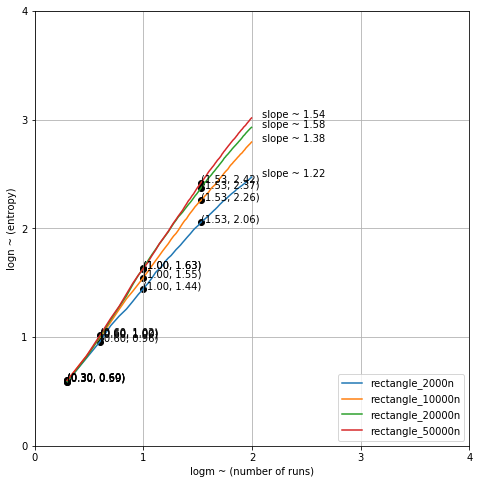

In [56]:
ax = plt.gca()
labels = ['rectangle_2000n', 'rectangle_10000n', 'rectangle_20000n', 'rectangle_50000n']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
    ax = addKPoints(np.log10(x), np.log10(entropies[i]), ax)

### more clusters
Given `nsamples = 40000`, When kClusters increases (`k>10`), the ID recovery is more accurate. The slope we found is `~1.85` which approximately recovers the ID=2

In [57]:
data = rectangle(nsamples=40000)

entropies = []
entropies.append(getEntropy(data, x, nIters, kClusters=2)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=30)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=50)[0])

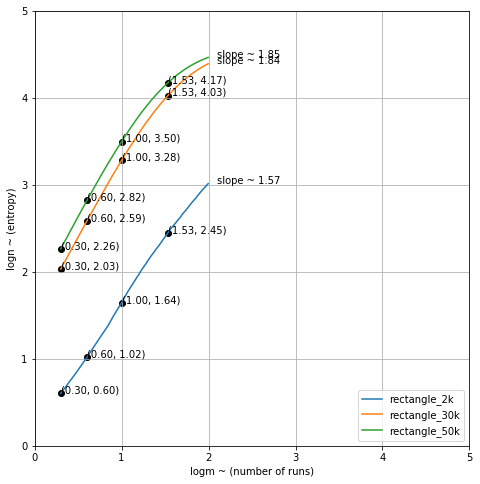

In [58]:
ax = plt.gca()
labels = ['rectangle_2k', 'rectangle_30k', 'rectangle_50k']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
    ax = addKPoints(np.log10(x), np.log10(entropies[i]), ax)

# Sin Wave

In [59]:
def sinwave(nsamples=5000):
    x = np.random.uniform(0,10,size=nsamples)
    y = np.sin(x) + np.random.normal(0,0.1,size=nsamples)
    plt.scatter(x,y)
    plt.ylim(-2,2)
    return np.stack([x,y]).T

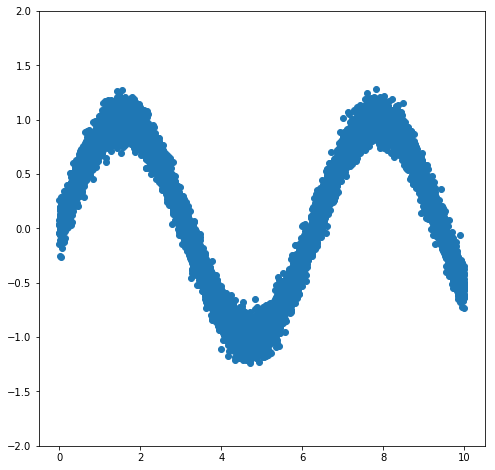

In [60]:
data = sinwave(nsamples=10000)

entropies = []
entropies.append(getEntropy(data, x, nIters, kClusters=2)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=10)[0])
entropies.append(getEntropy(data, x, nIters, kClusters=20)[0])
# entropies.append(getEntropy(data, x, nIters, kClusters=30)[0])

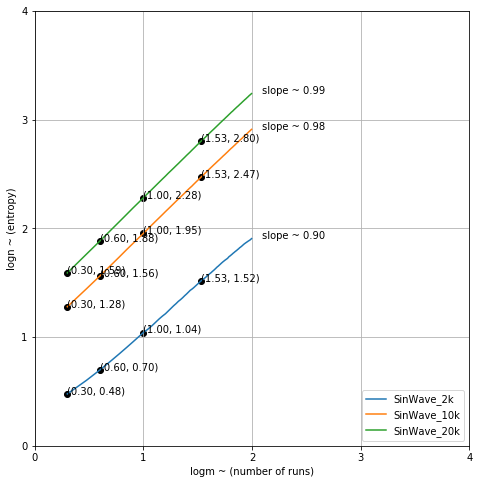

In [61]:
ax = plt.gca()
labels = ['SinWave_2k', 'SinWave_10k', 'SinWave_20k']
for i, entropy in enumerate(entropies):
    ax = gridplot(np.log10(x), np.log10(entropy), label=labels[i], ax=ax)
    ax = addKPoints(np.log10(x), np.log10(entropies[i]), ax)

Given `nsamples = 10000`, When kClusters increases (`k>10`), the ID recovery is more accurate. The slope we found ~0.99 which recovers the ID=1